In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import torch

In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project')

In [ ]:
from functions import show_tensor

### Select device

In [ ]:
device = torch.device("cuda")

### Create default or your own generator and EMA generator

In [ ]:
from generator import define_G

def make_generator():
    gen = define_G(input_nc = 3, output_nc = 3, ngf = 64, netG = "global", norm = "instance", n_downsample_global = 3, n_blocks_global = 9, n_local_enhancers = 1, n_blocks_local = 3).to(device)
    return gen
generator = make_generator()
generator_ema = make_generator()

# Initilalize generators with equal parameters
with torch.no_grad():
    for (gp, ep) in zip(generator.parameters(), generator_ema.parameters()):
        ep.data = gp.data.detach()

GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(512, 512, kernel_size

### Use the default or your own discriminator

In [ ]:
from discriminator import define_D

discriminator = define_D(input_nc = 3 + 3, ndf = 64, n_layers_D = 3, num_D = 3, norm="instance", getIntermFeat=True).to(device)

MultiscaleDiscriminator(
  (scale0_layer0): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer4): Sequential(
   

In [ ]:
import losses
criterionGAN = losses.GANLoss(use_lsgan=True).to(device)
criterionFeat = torch.nn.L1Loss().to(device)
criterionVGG = losses.VGGLoss().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.7MB/s]


In [ ]:
from replay_pool import ReplayPool
replay_pool = ReplayPool(10)

In [ ]:
G_optim = torch.optim.AdamW(generator.parameters(), lr=1e-4)
D_optim = torch.optim.AdamW(discriminator.parameters(), lr=1e-4)

### Modify the dataset class for your requirements

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
train_paths = {
    "src": [],
    "tar": []
}
val_paths = {
    "src": [],
    "tar": []
}

total_paths = {
    "src": [],
    "tar": []
}

for i in os.listdir("./drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project/data/satellite"):
  if i != 'classes.json':
    for j in os.listdir(f"./drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project/data/satellite/{i}/images/"):
      total_paths["src"].append(f"./drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project/data/satellite/{i}/images/{j}")
    for j in os.listdir(f"./drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project/data/satellite/{i}/masks/"):
      total_paths["tar"].append(f"./drive/MyDrive/colab-notebooks/btp/semantic-segmentation-project/data/satellite/{i}/masks/{j}")

In [ ]:
def split_array_by_percentage(array):
  split_index = int(len(array) * 0.7)
  return array[:split_index], array[split_index:]

train_paths["src"], val_paths["src"] = split_array_by_percentage(total_paths["src"])
train_paths["tar"], val_paths["tar"] = split_array_by_percentage(total_paths["tar"])

print(len(train_paths["src"]), len(val_paths["src"]))

50 22


In [ ]:
import matplotlib.pyplot as plt

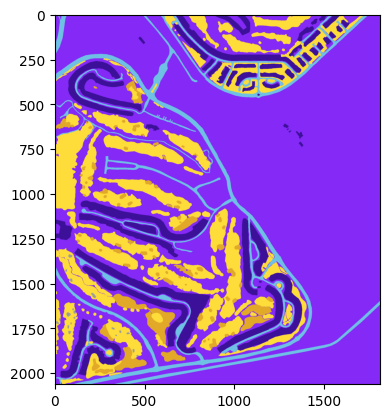

In [ ]:
src_image = cv2.imread(train_paths["src"][0], 1)
dst_image = cv2.imread(train_paths, 1)
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
dst_image = cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB)
plt.imshow()

In [ ]:
from torchvision import transforms
from random import uniform, randint
# from glob import glob
import os

class Dataset(torch.utils.data.Dataset):

    def __init__(self, src_paths, dst_paths):

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.src_paths = src_paths
        self.dst_paths = dst_paths


    def __getitem__(self, idx):
        from random import random, randint, uniform
        src_file= self.src_paths[idx]
        dst_file= self.dst_paths[idx]

        src_image = cv2.imread(src_file, 1)
        dst_image = cv2.imread(dst_file, 1)
        src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
        dst_image = cv2.cvtColor(dst_image, cv2.COLOR_BGR2RGB)
        dst = src_image
        src = dst_image

        w = 256
        h = 256

        # if random() < 0.5:
        #     src = np.fliplr(src)
        #     dst = np.fliplr(dst)

        src_tensor = self.to_tensor(src.copy())
        dst_tensor = self.to_tensor(dst.copy())
        return src_tensor, dst_tensor

    def __len__(self):
        return len(self.src_paths)


In [ ]:
batch_size = 1
train_dataset = Dataset(src_paths=train_paths["src"], dst_paths=train_paths["tar"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size)
test_dataset = Dataset(src_paths=val_paths["src"], dst_paths=val_paths["tar"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size)

In [ ]:
data, targets = next(iter(train_loader))

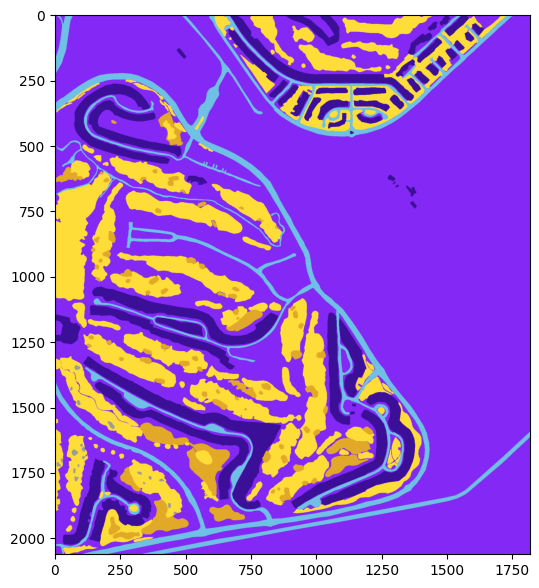

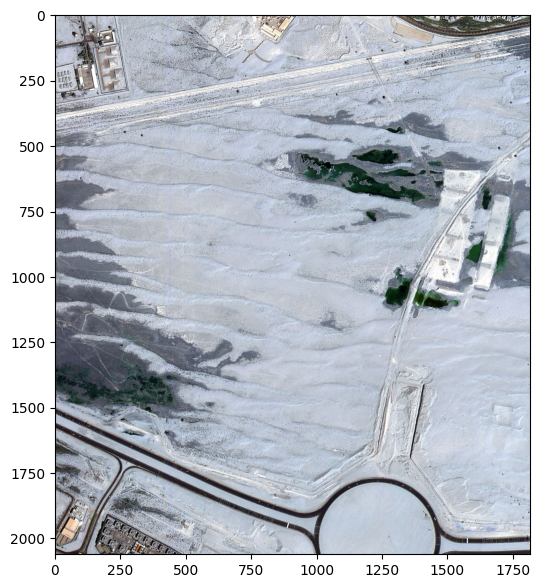

In [ ]:
show_tensor(data[0])
show_tensor(targets[0])

In [ ]:
checkpoint_dir = "./checkpoints/facades/"
images_output_dir = os.path.join(checkpoint_dir, "images")
if not os.path.exists(images_output_dir):
    os.makedirs(images_output_dir)

In [ ]:
import os
def test(epoch, iteration):
    with torch.no_grad():
        data, target = next(iter(test_loader))
        data = data.to(device)
        generator_ema.eval()
        out = generator_ema(data)
        generator_ema.train()
        matrix = []
        pairs = torch.cat([data, out, target.to(device)], -1)
        for idx in range(data.shape[0]):
            img = 255*(pairs[idx] + 1)/2
            img = img.cpu().permute(1, 2, 0).clip(0, 255).numpy().astype(np.uint8)
            matrix.append(img)
        matrix = np.vstack(matrix)
        matrix = cv2.cvtColor(matrix, cv2.COLOR_RGB2BGR)
        out_file = os.path.join(images_output_dir, f"{epoch}_{iteration}.jpg")
        cv2.imwrite(out_file, matrix)


In [ ]:
from moving_average import moving_average
from tqdm import tqdm

def process_loss(log, losses):
    loss = 0
    for k in losses:
        if k not in log:
            log[k] = 0
        log[k] += losses[k].item()
        loss = loss + losses[k]
    return loss

def calc_G_losses(data, target):
    fake = generator(data)
    loss_vgg = 1*criterionVGG(fake, target)
    pred_fake = discriminator(torch.cat([data, fake], axis=1))
    loss_adv = 1*criterionGAN(pred_fake, 1)

    with torch.no_grad():
        pred_true = discriminator(torch.cat([data, target], axis=1))

    loss_adv_feat = 0
    adv_feats_count = 0
    for d_fake_out, d_true_out in zip(pred_fake, pred_true):
        for l_fake, l_true in zip(d_fake_out[: -1], d_true_out[: -1]):
            loss_adv_feat = loss_adv_feat + criterionFeat(l_fake, l_true)
            adv_feats_count += 1
    loss_adv_feat = 1*(4/adv_feats_count)*loss_adv_feat
    lambda_feat = 10
    return {"G_vgg": loss_vgg, "G_adv": loss_adv, "G_adv_feat": lambda_feat*loss_adv_feat}

def calc_D_losses(data, target):
    with torch.no_grad():
        gen_out = generator(data)
        fake = replay_pool.query({"input": data.detach(), "output": gen_out.detach()})
    pred_true = discriminator(torch.cat([data, target], axis=1))
    loss_true = criterionGAN(pred_true, 1)
    pred_fake = discriminator(torch.cat([fake["input"], fake["output"]], axis=1))
    loss_false = criterionGAN(pred_fake, 0)
    return {"D_true": loss_true, "D_false": loss_false}

def train(epoch):

    print(f"Training epoch {epoch}...")
    generator.train()
    discriminator.train()
    N = 0
    log = {}
    pbar = tqdm(train_loader)
    for data, target in pbar:
        with torch.no_grad():
            data = data.to(device)
            target = target.to(device)

        G_optim.zero_grad()
        generator.requires_grad_(True)
        discriminator.requires_grad_(False)
        G_losses = calc_G_losses(data, target)
        G_loss = process_loss(log, G_losses)
        G_loss.backward()
        del G_losses
        G_optim.step()
        moving_average(generator, generator_ema)

        D_optim.zero_grad()
        generator.requires_grad_(False)
        discriminator.requires_grad_(True)
        D_losses = calc_D_losses(data, target)
        D_loss = process_loss(log, D_losses)
        D_loss.backward()
        del D_losses
        D_optim.step()

        txt = ""
        N += 1
        if (N%100 == 0) or (N + 1 >= len(train_loader)):
            for i in range(3):
                test(epoch, N + i)
        for k in log:
            txt += f"{k}: {log[k]/N:.3e} "
        pbar.set_description(txt)

        if (N%1000 == 0) or (N + 1 >= len(train_loader)):
            import datetime
            out_file = f"epoch_{epoch}_{datetime.datetime.now().strftime('%Y-%m-%d %H:%M')}.pt"
            out_file = os.path.join(checkpoint_dir, out_file)
            torch.save({"G": generator_ema.state_dict(), "D": discriminator.state_dict()}, out_file)
            print(f"Saved to {out_file}")

### Use the next lines for restoring from the checkpoint

In [ ]:
test(0, 0)

### Start

In [ ]:
for epoch in range(0, 100):
    train(epoch)